In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('GPU device found:')
    for device in physical_devices:
        print(device)
else:
    print('No GPU devices found.')

GPU device found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
SEED = 42
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def reset_seeds():
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)

reset_seeds()

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)


train_loc = './OfficialSpectrogramsMelAUG/train'
test_loc = './OfficialSpectrogramsMelAUG/test'
#image_size = (224, 224)
#batch_size = 32

# Definir la normalización
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Crear los generadores de datos
train_generator = train_datagen.flow_from_directory(
    directory=train_loc,
    target_size=(224,224),
    shuffle=True,
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    directory=test_loc,
    target_size=(224,224),
    shuffle=False,
    seed=SEED
)

# Definir funciones de generador
def train_generator_fn():
    for x_batch, y_batch in train_generator:
        yield x_batch, y_batch

def test_generator_fn():
    for x_batch, y_batch in test_generator:
        yield x_batch, y_batch

# Crear los datasets
train_dataset = tf.data.Dataset.from_generator(
    train_generator_fn,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None, len(train_generator.class_indices)])
)

test_dataset = tf.data.Dataset.from_generator(
    test_generator_fn,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None, len(test_generator.class_indices)])
)

train_dataset = train_dataset.repeat() \
                             .prefetch(buffer_size=tf.data.AUTOTUNE)

# Cálculo del número de pasos
validation_steps = test_generator.samples // test_generator.batch_size
if test_generator.samples % test_generator.batch_size != 0:
    validation_steps += 1 # Sumar 1 para el lote incompleto

# Aplicar el límite de pasos directamente al Dataset con .take()
test_dataset = test_dataset.take(validation_steps) \
                           .cache() \
                           .prefetch(buffer_size=tf.data.AUTOTUNE)

class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

vgg16 = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg16.layers:
    layer.trainable = False

for layer in vgg16.layers:
    # Congelar las primeras capas hasta 'block1'
    if 'block1' not in layer.name:
        layer.trainable = True
        print(f"Layer '{layer.name}' is now trainable")

x = vgg16.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
prediction = layers.Dense(len(class_names), activation='softmax', name='predictions')(x)

model = models.Model(inputs=vgg16.input, outputs=prediction)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9
Found 8544 images belonging to 4 classes.
Found 2756 images belonging to 4 classes.
Class names: ['crackle', 'crackle_wheeze', 'normal', 'wheeze']
Layer 'input_1' is now trainable
Layer 'block2_conv1' is now trainable
Layer 'block2_conv2' is now trainable
Layer 'block2_pool' is now trainable
Layer 'block3_conv1' is now trainable
Layer 'block3_conv2' is now trainable
Layer 'block3_conv3' is now trainable
Layer 'block3_pool' is now trainable
Layer 'block4_conv1' is now trainable
Layer 'block4_conv2' is now trainable
Layer 'block4_conv3' is now trainable
Layer 'block4_pool' is now trainable
Layer 'block5_conv1' is now trainable
Layer 'block5_conv2' is now trainable
Layer 'block5_conv3' is now trainable
Layer 'block5_pool' is now trainable
Model: "model

In [4]:
# Callback personalizado para monitorear dos métricas y una condición adicional
class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, filepath, monitor1='val_accuracy', monitor2='val_loss', mode1='max', mode2='min', save_best_only=True, ignore_initial_epochs=15, verbose=0, loss_threshold=3):
        super().__init__()
        self.filepath = filepath
        self.monitor1 = monitor1
        self.monitor2 = monitor2
        self.mode1 = mode1
        self.mode2 = mode2
        self.save_best_only = save_best_only
        self.ignore_initial_epochs = ignore_initial_epochs
        self.verbose = verbose
        self.loss_threshold = loss_threshold
        self.best = None  # Guardamos la mejor métrica principal
        self.best_epoch = -1

    def on_epoch_end(self, epoch, logs=None):
        if epoch < self.ignore_initial_epochs:
            return
        
        current1 = logs.get(self.monitor1)
        current2 = logs.get(self.monitor2)

        if current2 < self.loss_threshold and (self.best is None or self._compare(current1, self.best, self.mode1)):
            self.best = current1
            self.best_epoch = epoch
            if self.verbose > 0:
                print(f"\nEpoch {epoch + 1}: {self.monitor1} improved to {current1}, {self.monitor2} is {current2}, saving model to {self.filepath}")
            if self.save_best_only:
                self.model.save(self.filepath, overwrite=True)
            else:
                self.model.save(self.filepath.format(epoch=epoch, **logs))
        else:
            if self.verbose > 0:
                # La precisión no mejoró o la pérdida falló.
                if current2 >= self.loss_threshold:
                    print(f"\nEpoch {epoch + 1}: Val loss ({current2:.4f}) is >= threshold ({self.loss_threshold:.1f}). No model saved.")
                else:
                    print(f"\nEpoch {epoch + 1}: {self.monitor1} did not improve from {self.best:.4f}. Val loss is {current2:.4f}. No model saved.")

    def _compare(self, current, best, mode):
        if best is None:
            return True
        if mode == 'max':
            return current > best
        else:  # mode == 'min'
            return current < best


# Callback personalizado para EarlyStopping
class CustomEarlyStopping(callbacks.EarlyStopping):
    def __init__(self, *args, ignore_initial_epochs=3, **kwargs):
        super().__init__(*args, **kwargs)
        self.ignore_initial_epochs = ignore_initial_epochs
        self.wait = 0  # To track the number of epochs since the best score was improved

    def on_epoch_end(self, epoch, logs=None):
        if epoch >= self.ignore_initial_epochs:
            super().on_epoch_end(epoch, logs)

In [5]:
# Ruta para guardar el modelo
checkpoint_path = './Best_Models/Official/Adam/VGG16_Adam_00005.h5'

IGNORE_INITIAL_EPOCHS=5

# Callback para guardar el mejor modelo basado en la precisión en el conjunto de validación
checkpoint_callback = CustomModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    ignore_initial_epochs=IGNORE_INITIAL_EPOCHS
)
early_acc = CustomEarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=40, verbose=1, mode='max',
    ignore_initial_epochs=IGNORE_INITIAL_EPOCHS
)
early_loss = CustomEarlyStopping(
    monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='min',
    ignore_initial_epochs=IGNORE_INITIAL_EPOCHS
)

In [6]:
from collections import Counter

counter = Counter(train_generator.classes)                       
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.0, 1: 1.564657393096342, 2: 1.4721279689772175, 3: 2.0206254158349966}

In [7]:
# Train the model
history = model.fit(train_dataset, validation_data=test_dataset,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    epochs=250, callbacks=[checkpoint_callback, early_acc, early_loss], verbose=2, class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Validation loss:", loss)
print("Validation accuracy:", accuracy)

Epoch 1/250
267/267 - 56s - loss: 1.9787 - accuracy: 0.2660 - val_loss: 1.3897 - val_accuracy: 0.0526 - 56s/epoch - 211ms/step
Epoch 2/250
267/267 - 31s - loss: 1.9706 - accuracy: 0.2640 - val_loss: 1.3858 - val_accuracy: 0.1397 - 31s/epoch - 115ms/step
Epoch 3/250
267/267 - 33s - loss: 1.9691 - accuracy: 0.3000 - val_loss: 1.4006 - val_accuracy: 0.1705 - 33s/epoch - 125ms/step
Epoch 4/250
267/267 - 34s - loss: 1.9612 - accuracy: 0.2972 - val_loss: 1.5215 - val_accuracy: 0.1488 - 34s/epoch - 126ms/step
Epoch 5/250
267/267 - 34s - loss: 1.9574 - accuracy: 0.3237 - val_loss: 1.3751 - val_accuracy: 0.1967 - 34s/epoch - 126ms/step
Epoch 6/250

Epoch 6: val_accuracy improved to 0.17888243496418, val_loss is 1.3780502080917358, saving model to ./Best_Models/Official/Adam/VGG16_Adam_00005.h5
267/267 - 34s - loss: 1.9501 - accuracy: 0.3407 - val_loss: 1.3781 - val_accuracy: 0.1789 - 34s/epoch - 127ms/step
Epoch 7/250

Epoch 7: val_accuracy improved to 0.4680696725845337, val_loss is 1.17302584

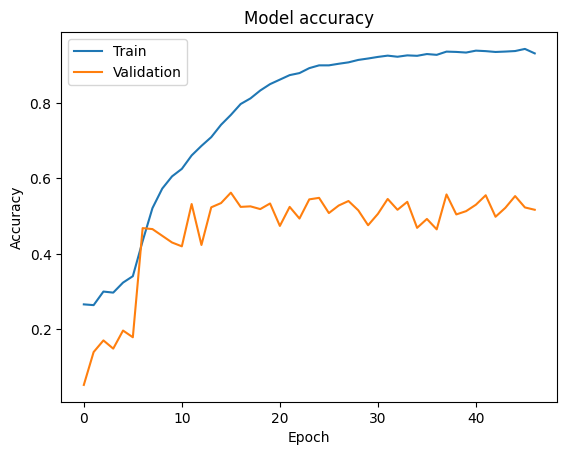

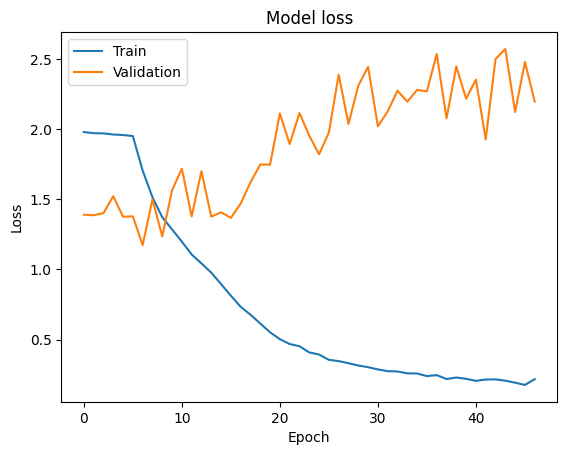

In [8]:
import matplotlib.pyplot as plt

# Plotear el accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotear el loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Predicciones en el conjunto de prueba
predictions = model.predict(test_generator)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes

# Convertir las predicciones en etiquetas de clase
y_pred_classes = np.argmax(predictions, axis=1)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Obtener el número total de predicciones correctas para cada clase
Pc = sum((y_true == 0) & (y_pred_classes == 0))  # Crackle
Pb = sum((y_true == 1) & (y_pred_classes == 1))  # Both
Pn = sum((y_true == 2) & (y_pred_classes == 2))  # Normal
Pw = sum((y_true == 3) & (y_pred_classes == 3))  # Wheeze

# Obtener el total de muestras para cada clase
Crackle_total = sum(y_true == 0)  # Total de muestras de la clase Crackle
Both_total = sum(y_true == 1)     # Total de muestras de la clase Both
Normal_total = sum(y_true == 2)   # Total de muestras de la clase Normal
Wheeze_total = sum(y_true == 3)   # Total de muestras de la clase Wheeze

# Calcular el puntaje Se (Sensibilidad)
Se = (Pc + Pw + Pb) / (Crackle_total + Wheeze_total + Both_total)

# Calcular el puntaje Sp (Especificidad)
Sp = Pn / Normal_total

# Calcular el puntaje promedio
score = (Se + Sp) / 2

# Mostrar los resultados
print("Puntaje de Sensibilidad (Se):", Se)
print("Puntaje de Especificidad (Sp):", Sp)
print("Puntaje promedio:", score)

87/87 [==============================] - 11s 125ms/step
Accuracy: 0.5166908563134979
Precision: 0.5381805448675213
Recall: 0.5166908563134979
F1 Score: 0.525689282329868
Puntaje de Sensibilidad (Se): 0.372982158028887
Puntaje de Especificidad (Sp): 0.6238125395820139
Puntaje promedio: 0.49839734880545045


In [10]:
# Mostrar el informe de clasificación
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
                precision    recall  f1-score   support

       crackle       0.42      0.40      0.41       649
crackle_wheeze       0.14      0.18      0.16       143
        normal       0.68      0.62      0.65      1579
        wheeze       0.31      0.41      0.35       385

      accuracy                           0.52      2756
     macro avg       0.39      0.40      0.39      2756
  weighted avg       0.54      0.52      0.53      2756



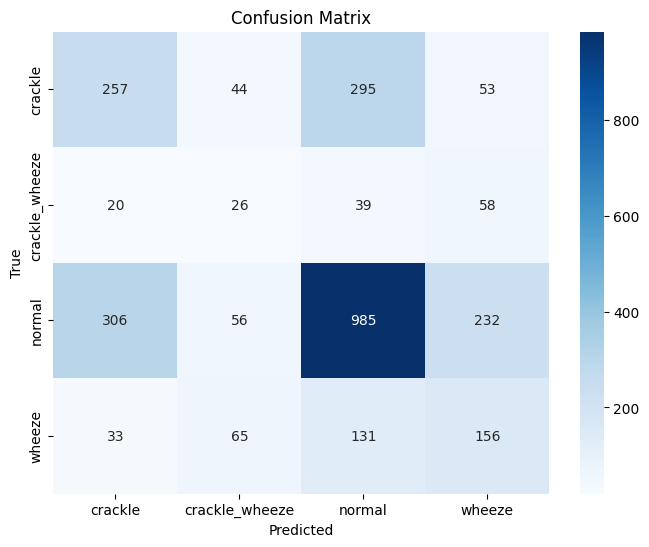

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para mostrar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, class_names):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Calcular y mostrar la matriz de confusión
plot_confusion_matrix(y_true, y_pred_classes, class_names)

In [ ]:
# Save the trained model
#model.save('./Best_Models/Official/Adam/VGG16_Adam_00005.h5')